# **Desenho do experimento**

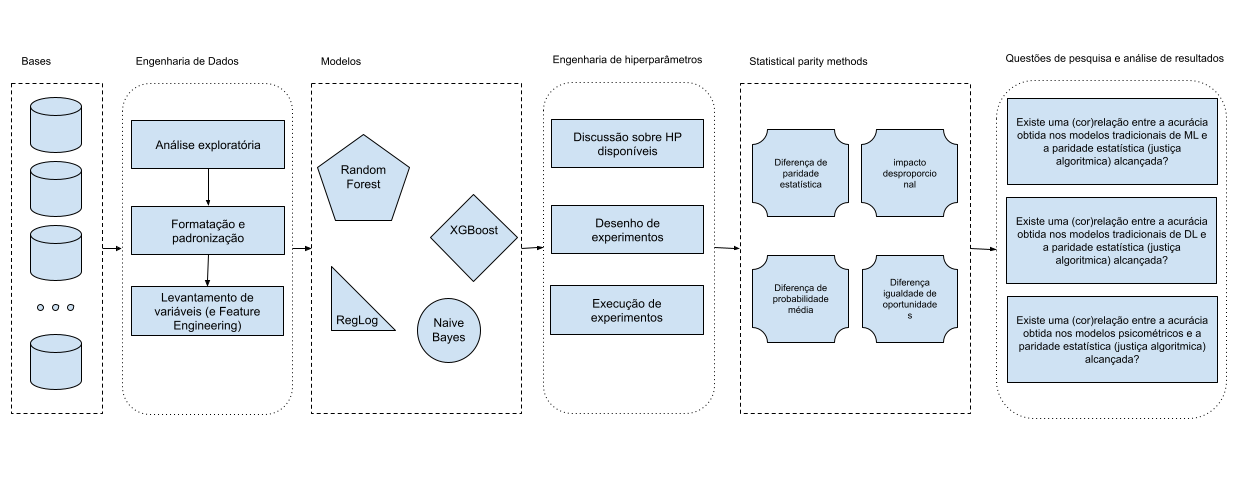

# Importações e instalações de biblioteca

In [23]:
!pip install 'aif360[Reductions,inFairness]'
!pip install xlrd


In [24]:

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import ast
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier

In [25]:
# Fairness lib
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.postprocessing import EqOddsPostprocessing

2024-04-10 10:29:16.255982: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-10 10:29:19.216648: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/tuao/anaconda3/envs/aif360/lib/python3.11/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


# Métodos de verificação de vieses

## Funções

In [26]:
def justica_exps(base, attr_set, df, parametros, modelo, categorical_features, label, fvr_classes, prt_attrs, priv_classes):

  # criando data set no formato adequado (classe Standard Dataset)
  df2model = StandardDataset(df,
                            label_name=label,
                            favorable_classes=fvr_classes,
                            protected_attribute_names=prt_attrs,
                            privileged_classes=priv_classes)

  i = 0
  results = []
  for param_set in parametros:
    result_grid = {}
    print(type(param_set))
    print(param_set)

    # Estabelecendo conjunto de parametros para o modelo
    # Criando modelo
    if modelo == 'gbt':
      clf = GradientBoostingClassifier(n_estimators = param_set['n_estimators'],
                                        min_samples_split = param_set['min_samples_split'],
                                        learning_rate = param_set['learning_rate'],
                                        max_depth = param_set['max_depth'],
                                        random_state = param_set['random_state'])
    elif modelo == 'rf':
      clf = RandomForestClassifier(n_estimators = param_set['n_estimators'],
                                  min_samples_split = param_set['min_samples_split'],
                                  criterion = param_set['criterion'],
                                  max_depth = param_set['max_depth'],
                                  random_state = param_set['random_state'])
    else:
      print("Modelos suportados atualmente: 'gbt' e 'rf'. ")

    # Separando teste e treino
    df2_train, df2_test = df2model.split([0.7], shuffle=True)

    # Fitando o modelo na base de treino
    model = clf.fit(df2_train.features, df2_train.labels.ravel())

    # Formatando base de teste
    x_df2_test = df2_test.features
    y_df2_test = df2_test.labels.ravel()

    # Criando copia da base para predição
    dataset = df2_test
    dataset_pred = dataset.copy()
    dataset_pred.labels = model.predict(df2_test.features)

    # # Definindo as populações privilegiadas e não-privilegiadas
    # # Sexo
    # ## Recuperando o indice
    # privileged_sex   = np.where(categorical_names['Sexo'] == 'male')[0]
    # unprivileged_sex = np.where(categorical_names['Sexo'] == 'female')[0]
    # ## Estabelecendo formato, seguindo o formato da documentacao das classes ClassificationMetric and BinaryLabelDatasetMetric
    # privileged_groups   = [{'Sexo' : privileged_sex}]
    # unprivileged_groups = [{'Sexo' : unprivileged_sex}]

    # Criando classes de populacoes
    classified_metric_sex = ClassificationMetric(dataset,
                                                 dataset_pred,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)

    metric_pred_sex = BinaryLabelDatasetMetric(dataset_pred,
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)

    # # Idade
    # ## Recuperando o indice
    # privileged_faixa_etaria   = np.where(categorical_names['faixa_etaria'] == 'adulto')[0]
    # unprivileged_faixa_etaria = np.where(categorical_names['faixa_etaria'] == 'jovem')[0]
    # ## Estabelecendo formato, seguindo o formato da documentacao das classes ClassificationMetric and BinaryLabelDatasetMetric
    # privileged_groups_fe   = [{'faixa_etaria' : privileged_faixa_etaria}]
    # unprivileged_groups_fe = [{'faixa_etaria' : unprivileged_faixa_etaria}]

    # Criando classes de populacoes
    classified_metric_faixa_etaria = ClassificationMetric(dataset,
                                                          dataset_pred,
                                                          unprivileged_groups=unprivileged_groups_fe,
                                                          privileged_groups=privileged_groups_fe)

    metric_pred_faixa_etaria = BinaryLabelDatasetMetric(dataset_pred,
                                                        unprivileged_groups=unprivileged_groups_fe,
                                                        privileged_groups=privileged_groups_fe)

    # Submetendo modelo ao 10-fold cross validation (fitting)
    # obtendo acurácia
    scores1 = cross_val_score(clf, df2_train.features, df2_train.labels.ravel(), cv=10)
    print("%0.2f de acuracia com desvio padrão de %0.2f" % (scores1.mean(), scores1.std()))
    # obtendo f1_score
    scores2 = cross_val_score(clf, df2_train.features, df2_train.labels.ravel(), cv=10,scoring='f1_macro')
    print("%0.2f de f1 com desvio padrão de %0.2f" % (scores2.mean(), scores2.std()))
    # obtendo precisão
    scores3 = cross_val_score(clf, df2_train.features, df2_train.labels.ravel(), cv=10,scoring='precision')
    print("%0.2f de precisão com desvio padrão de %0.2f" % (scores3.mean(), scores3.std()))

    # Obtendo o score no teste
    model = clf.fit(df2_train.features, df2_train.labels.ravel())
    score4 = model.score(x_df2_test, y_df2_test)
    print("%0.2f de score no teste" % (score4))

    # Métricas de justica algoritmica
    print('STATISTICAL PARITY DIFFERENCE')
    spd_sexo = metric_pred_sex.statistical_parity_difference()
    spd_faixa_etaria = metric_pred_faixa_etaria.statistical_parity_difference()

    print(f'Atributo sexo: {spd_sexo}')
    print(f'Atributo faixa_etaria: {spd_faixa_etaria}')

    print('')

    print('DISPARATE IMPACT')
    di_sexo = metric_pred_sex.disparate_impact()
    di_faixa_etaria = metric_pred_faixa_etaria.disparate_impact()

    print(f'Atributo sexo: {di_sexo}')
    print(f'Atributo faixa_etaria: {di_faixa_etaria}')

    print(' ')

    print('AVERAGE ODDS DIFFERENCE')
    aod_sexo = classified_metric_sex.average_odds_difference()
    aod_faixa_etaria = classified_metric_faixa_etaria.average_odds_difference()

    print(f'Atributo sexo: {aod_sexo}')
    print(f'Atributo faixa_etaria: {aod_faixa_etaria}')

    print(' ')

    print('EQUAL OPPORTUNITY DIFFERENCE')

    eod_sexo = classified_metric_sex.equal_opportunity_difference()
    eod_faixa_etaria = classified_metric_faixa_etaria.equal_opportunity_difference()
    print(f'Atributo sexo: {eod_sexo}')
    print(f'Atributo faixa_etaria: {eod_faixa_etaria}')

    # collecting results
    result_grid['index'] = i
    result_grid['base'] = base
    result_grid['attr_set'] = attr_set
    result_grid['modelo'] = modelo
    result_grid['param_set'] = str(param_set)
    result_grid['10fold-acuracia'] = scores1.mean()
    result_grid['10fold-f1'] = scores2.mean()
    result_grid['10fold-precisao'] = scores3.mean()
    result_grid['test-score'] = score4
    result_grid['spd_sexo'] = spd_sexo
    result_grid['spd_faixa_etaria'] = spd_faixa_etaria
    result_grid['di_sexo'] = di_sexo
    result_grid['di_faixa_etaria'] = di_faixa_etaria
    result_grid['aod_sexo'] = aod_sexo
    result_grid['aod_faixa_etaria'] = aod_faixa_etaria
    result_grid['eod_sexo'] = eod_sexo
    result_grid['eod_faixa_etaria'] = eod_faixa_etaria

    results.append(result_grid)
    i += 1
    print(result_grid)
    print("")
  return result_grid

# Lendo e preprocessando a base de dados

In [27]:
base = 'german'
german = pd.read_csv('Datasets/german(mais_novo).csv', sep='\s+')
german.head(3)

,ContaCorrente,DuracaodoCred,HistoricoCred,PropositoCred,ValorCred,Poup_Titulos,Tmp_Emprego_Atual,TxParc_PorcRendaDisp,EstCivil_Sexo,OutrosDevedores_Fiadores,ResidAtualDesde,Propriedade,Idade,OutrosPlanosParc,Moradia,NumCredExistentesNoBanco,Emprego,NumPessoasRespManut,Telefone,TrabEstrangeiro,class
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201,1


**Recodificando classes (0 e 1)**

De: [1 = Good, 2 = Bad] ---> Para: [1 = Good, 0 = Bad]

In [28]:
german.loc[german['class'] == 2, 'class'] = 0

In [29]:
german.head(3)

,ContaCorrente,DuracaodoCred,HistoricoCred,PropositoCred,ValorCred,Poup_Titulos,Tmp_Emprego_Atual,TxParc_PorcRendaDisp,EstCivil_Sexo,OutrosDevedores_Fiadores,ResidAtualDesde,Propriedade,Idade,OutrosPlanosParc,Moradia,NumCredExistentesNoBanco,Emprego,NumPessoasRespManut,Telefone,TrabEstrangeiro,class
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201,0
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201,1


**Produzindo categorias para faixa etária**

In [30]:
# # faixas etarias retiradas de: https://www.americanexpress.com/en-us/credit-cards/credit-intel/credit-score-by-age-state/
# german.loc[german['Idade']<=18, 'age_group'] = 'under-18'
# german.loc[german['Idade'].between(18,24), 'age_group'] = 'yadult'
# german.loc[german['Idade'].between(25,40), 'age_group'] = 'adult'
# german.loc[german['Idade'].between(41,56), 'age_group'] = 'madult'
# german.loc[german['Idade'].between(55,75), 'age_group'] = 'oadult'
# german.loc[german['Idade']>76, 'age_group'] = 'elder'
# german.head()

In [31]:
# Tem que ser binário
# faixas etarias retiradas de: https://www.americanexpress.com/en-us/credit-cards/credit-intel/credit-score-by-age-state/
german.loc[german['Idade']<=24, 'faixa_etaria'] = 'jovem'
german.loc[german['Idade']>24, 'faixa_etaria'] = 'adulto'
german.head()

,ContaCorrente,DuracaodoCred,HistoricoCred,PropositoCred,ValorCred,Poup_Titulos,Tmp_Emprego_Atual,TxParc_PorcRendaDisp,EstCivil_Sexo,OutrosDevedores_Fiadores,ResidAtualDesde,Propriedade,Idade,OutrosPlanosParc,Moradia,NumCredExistentesNoBanco,Emprego,NumPessoasRespManut,Telefone,TrabEstrangeiro,class,faixa_etaria
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201,1,adulto
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201,0,jovem
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201,1,adulto
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201,1,adulto
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201,0,adulto


**Produzindo categoria binária de sexo**

In [32]:
  #'EstCivil_Sexo_A91' = Male Single/Divorced/Separated
  #'EstCivil_Sexo_A92' = Female Single/Divorced/Separated
  #'EstCivil_Sexo_A93' = Male Married/Widowed
  #'EstCivil_Sexo_A94' = Female Married/Widowed
german.loc[german['EstCivil_Sexo'].isin(["A91","A93"]), 'Sexo'] = 'male'
german.loc[german['EstCivil_Sexo'].isin(["A92","A94"]), 'Sexo'] = 'female'
german.head(3)

,ContaCorrente,DuracaodoCred,HistoricoCred,PropositoCred,ValorCred,Poup_Titulos,Tmp_Emprego_Atual,TxParc_PorcRendaDisp,EstCivil_Sexo,OutrosDevedores_Fiadores,ResidAtualDesde,Propriedade,Idade,OutrosPlanosParc,Moradia,NumCredExistentesNoBanco,Emprego,NumPessoasRespManut,Telefone,TrabEstrangeiro,class,faixa_etaria,Sexo
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201,1,adulto,male
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201,0,jovem,female
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201,1,adulto,male


In [33]:
german.dtypes

ContaCorrente               object
DuracaodoCred                int64
HistoricoCred               object
PropositoCred               object
ValorCred                    int64
Poup_Titulos                object
Tmp_Emprego_Atual           object
TxParc_PorcRendaDisp         int64
EstCivil_Sexo               object
OutrosDevedores_Fiadores    object
ResidAtualDesde              int64
Propriedade                 object
Idade                        int64
OutrosPlanosParc            object
Moradia                     object
NumCredExistentesNoBanco     int64
Emprego                     object
NumPessoasRespManut          int64
Telefone                    object
TrabEstrangeiro             object
class                        int64
faixa_etaria                object
Sexo                        object
dtype: object

In [34]:
# separando rótulo (variável dependente y)
german_y = german['class']

## Codificando categóricas

In [35]:
categorical_features = [i for i in german.columns if german.dtypes[i] in ['object', 'category']]
categorical_features

['ContaCorrente',
 'HistoricoCred',
 'PropositoCred',
 'Poup_Titulos',
 'Tmp_Emprego_Atual',
 'EstCivil_Sexo',
 'OutrosDevedores_Fiadores',
 'Propriedade',
 'OutrosPlanosParc',
 'Moradia',
 'Emprego',
 'Telefone',
 'TrabEstrangeiro',
 'faixa_etaria',
 'Sexo']

In [36]:
categorical_names = {}
encoders = {}

for feature in categorical_features:
  le = LabelEncoder()
  le.fit(german[feature])

  german[feature] = le.transform(german[feature])

  categorical_names[feature] = le.classes_
  encoders[feature] = le

In [37]:
german = german.astype(int)
german.dtypes
# todos devem estar codificados em int64

ContaCorrente               int64
DuracaodoCred               int64
HistoricoCred               int64
PropositoCred               int64
ValorCred                   int64
Poup_Titulos                int64
Tmp_Emprego_Atual           int64
TxParc_PorcRendaDisp        int64
EstCivil_Sexo               int64
OutrosDevedores_Fiadores    int64
ResidAtualDesde             int64
Propriedade                 int64
Idade                       int64
OutrosPlanosParc            int64
Moradia                     int64
NumCredExistentesNoBanco    int64
Emprego                     int64
NumPessoasRespManut         int64
Telefone                    int64
TrabEstrangeiro             int64
class                       int64
faixa_etaria                int64
Sexo                        int64
dtype: object

In [38]:
german.head(5)

,ContaCorrente,DuracaodoCred,HistoricoCred,PropositoCred,ValorCred,Poup_Titulos,Tmp_Emprego_Atual,TxParc_PorcRendaDisp,EstCivil_Sexo,OutrosDevedores_Fiadores,ResidAtualDesde,Propriedade,Idade,OutrosPlanosParc,Moradia,NumCredExistentesNoBanco,Emprego,NumPessoasRespManut,Telefone,TrabEstrangeiro,class,faixa_etaria,Sexo
0,0,6,4,4,1169,4,4,4,2,0,4,0,67,2,1,2,2,1,1,0,1,0,1
1,1,48,2,4,5951,0,2,2,1,0,2,0,22,2,1,1,2,1,0,0,0,1,0
2,3,12,4,7,2096,0,3,2,2,0,3,0,49,2,1,1,1,2,0,0,1,0,1
3,0,42,2,3,7882,0,3,2,2,2,4,1,45,2,2,1,2,2,0,0,1,0,1
4,0,24,3,0,4870,0,2,3,2,0,4,3,53,2,2,2,2,2,0,0,0,0,1


In [39]:
# Definições sobre os dados para avaliação de justiça
label_name ='class'
protected_attribute_names = ['Sexo', 'faixa_etaria']
favorable_classes = np.where(german['class'] == 1)[0]

# Definição de categoria privilegiada para cada atributo protegido
  #'EstCivil_Sexo_A91' = Male Single/Divorced/Separated
  #'EstCivil_Sexo_A92' = Female Single/Divorced/Separated
  #'EstCivil_Sexo_A93' = Male Married/Widowed
  #'EstCivil_Sexo_A94' = Female Married/Widowed

# Definindo as populações privilegiadas e não-privilegiadas
# Sexo
## Recuperando o indice
privileged_sex   = np.where(categorical_names['Sexo'] == 'male')[0]
unprivileged_sex = np.where(categorical_names['Sexo'] == 'female')[0]
## Estabelecendo formato, seguindo o formato da documentacao das classes ClassificationMetric and BinaryLabelDatasetMetric
privileged_groups   = [{'Sexo' : privileged_sex}]
unprivileged_groups = [{'Sexo' : unprivileged_sex}]

# Idade
## Recuperando o indice
privileged_faixa_etaria   = np.where(categorical_names['faixa_etaria'] == 'adulto')[0]
unprivileged_faixa_etaria = np.where(categorical_names['faixa_etaria'] == 'jovem')[0]
## Estabelecendo formato, seguindo o formato da documentacao das classes ClassificationMetric and BinaryLabelDatasetMetric
privileged_groups_fe   = [{'faixa_etaria' : privileged_faixa_etaria}]
unprivileged_groups_fe = [{'faixa_etaria' : unprivileged_faixa_etaria}]


# Dados privilegiados
privileged_classes = [privileged_sex, privileged_faixa_etaria]

In [40]:
favorable_classes

array([  0,   2,   3,   5,   6,   7,   8,  12,  14,  16,  17,  19,  20,
        21,  22,  23,  24,  25,  26,  27,  28,  30,  31,  32,  33,  34,
        36,  38,  39,  40,  41,  42,  43,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  55,  57,  58,  60,  61,  64,  65,  66,  67,  69,
        70,  71,  72,  73,  75,  77,  78,  79,  81,  82,  83,  84,  85,
        86,  88,  90,  91,  93,  94,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 107, 108, 109, 110, 111, 112, 114, 115, 117, 119, 121,
       122, 123, 125, 126, 128, 130, 132, 133, 134, 135, 136, 138, 139,
       140, 141, 142, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 167, 168,
       171, 173, 176, 177, 178, 179, 183, 185, 187, 189, 193, 196, 198,
       200, 201, 202, 204, 205, 206, 207, 208, 209, 210, 211, 214, 215,
       216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 229, 231, 232,
       233, 234, 238, 239, 241, 243, 244, 245, 246, 247, 248, 25

In [41]:
favorable_classes[0]

0

In [42]:
len(german)

1000

In [43]:
# Cooperativas de crédito ou coletivos
attr_set1_alternativos = ["Idade", "Sexo", "Emprego", "Moradia", "Poup_Titulos", "ContaCorrente", "ValorCred",
                      "DuracaodoCred", "PropositoCred", "faixa_etaria", "class"]
german_alternativos = german[attr_set1_alternativos]


# Bancos publicos ou de fomento
attr_set2_publicos = ["Idade", "Emprego", "Moradia", "Poup_Titulos", "ValorCred", "DuracaodoCred", "PropositoCred", "Sexo", "faixa_etaria", "class"]
german_publicos = german[attr_set2_publicos]

# Fintechs ou startups
attr_set3_fintechs = ["Idade", "Sexo", "Emprego", "Moradia", "Poup_Titulos", "ContaCorrente", "ValorCred",
                      "DuracaodoCred", "PropositoCred", "faixa_etaria", "class"]
german_fintechs = german[attr_set3_fintechs]

# Preparando experimentos

In [44]:
np.random.seed(2024)

In [45]:
list_gbt_params = []
for estimators in range(100, 500, 100):
  for samples in range(50, 300, 50):
    for learning in [0.1, 0.2, 0.3, 0.4, 0.5]:
      for depth in range(2, 8, 1):
        gbt_p = {}
        RANDOM_STATE = 2024
        gbt_p['n_estimators'] = estimators
        gbt_p['min_samples_split'] = samples
        gbt_p['learning_rate'] = learning
        gbt_p['max_depth'] = depth
        gbt_p['random_state'] = RANDOM_STATE
        list_gbt_params.append(gbt_p)

# print(*(x for x in list_gbt_params), sep='\n')
print("Total de {} conjuntos de parâmetros.".format(len(list_gbt_params)))

Total de 600 conjuntos de parâmetros.


In [46]:
list_rf_params = []
for estimators in range(100, 500, 100):
  for samples in range(50, 300, 50):
    for learning in ['gini', 'entropy']:
      for depth in range(2, 8, 1):
        rf_p = {}
        RANDOM_STATE = 2024
        rf_p['n_estimators'] = estimators
        rf_p['min_samples_split'] = samples
        rf_p['criterion'] = learning
        rf_p['max_depth'] = depth
        rf_p['random_state'] = RANDOM_STATE
        list_rf_params.append(rf_p)

# print(*(x for x in list__params), sep='\n')
print("Total de {} conjuntos de parâmetros.".format(len(list_rf_params)))

Total de 240 conjuntos de parâmetros.


# Toda a base

In [47]:
#

### GBT

In [48]:
exp1_all_gbt = justica_exps(base, 'toda-a-base', german, list_gbt_params, 'gbt', categorical_features, 'class', favorable_classes, protected_attribute_names, privileged_classes)

<class 'dict'>
{'n_estimators': 100, 'min_samples_split': 50, 'learning_rate': 0.1, 'max_depth': 2, 'random_state': 2024}


0.74 de acuracia com desvio padrão de 0.04
0.65 de f1 com desvio padrão de 0.06
0.77 de precisão com desvio padrão de 0.04
0.78 de score no teste
STATISTICAL PARITY DIFFERENCE
Atributo sexo: 0.06081113056646634
Atributo faixa_etaria: 0.20210409745293467

DISPARATE IMPACT
Atributo sexo: 1.37905604719764
Atributo faixa_etaria: 2.303571428571429
 
AVERAGE ODDS DIFFERENCE
Atributo sexo: 0.03417082853118198
Atributo faixa_etaria: 0.18083766996810474
 
EQUAL OPPORTUNITY DIFFERENCE
Atributo sexo: 0.027368421052631597
Atributo faixa_etaria: 0.16602316602316597
{'index': 0, 'base': 'german', 'attr_set': 'toda-a-base', 'modelo': 'gbt', 'param_set': "{'n_estimators': 100, 'min_samples_split': 50, 'learning_rate': 0.1, 'max_depth': 2, 'random_state': 2024}", '10fold-acuracia': 0.7357142857142858, '10fold-f1': 0.6487039925095617, '10fold-precisao': 0.7732413130326015, 'test-score': 0.7766666666666666, 'spd_sexo': 0.06081113056646634, 'spd_faixa_etaria': 0.20210409745293467, 'di_sexo': 1.37905604719

KeyboardInterrupt: 

### RF

In [ ]:
exp2_all_rf = justica_exps(base, 'toda-a-base', german, list_rf_params, 'rf', categorical_features, 'class', favorable_classes, protected_attribute_names, privileged_classes)

<class 'dict'>
{'n_estimators': 100, 'min_samples_split': 50, 'criterion': 'gini', 'max_depth': 2, 'random_state': 2024}


TypeError: RandomForestClassifier.__init__() got an unexpected keyword argument 'learning_rate'

# Atributos de bancos alternativos

In [ ]:
#

### GBT

In [ ]:
exp3_alt_gbt = justica_exps(base, 'alternativos', german_alternativos, list_gbt_params, 'gbt', categorical_features, 'class', favorable_classes, protected_attribute_names, privileged_classes)

### RF

In [ ]:
exp4_alt_rf = justica_exps(base, 'alternativos', german, list_rf_params, 'rf', categorical_features, 'class', favorable_classes, protected_attribute_names, privileged_classes)

# Atributos de bancos publicos

In [ ]:
#

### GBT

In [ ]:
exp5_pub_gbt = justica_exps(base, 'publicos', german_alternativos, list_gbt_params, 'gbt', categorical_features, 'class', favorable_classes, protected_attribute_names, privileged_classes)

### RF

In [ ]:
 exp6_pub_rf = justica_exps(base, 'publicos', german, list_rf_params, 'rf', categorical_features, 'class', favorable_classes, protected_attribute_names, privileged_classes)

# Atributos de fintechs

In [ ]:
#

### GBT

In [ ]:
exp7_fin_gbt = justica_exps(base, 'fintechs', german_alternativos, list_gbt_params, 'gbt', categorical_features, 'class', favorable_classes, protected_attribute_names, privileged_classes)

### RF

In [ ]:
exp8_fin_rf = justica_exps(base, 'fintechs', german, list_rf_params, 'rf', categorical_features, 'class', favorable_classes, protected_attribute_names, privileged_classes)